In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
from glob import glob
from dask import bag
from PIL import Image, ImageDraw
import tensorflow as tf
from tqdm import tqdm
from tensorflow.python.framework import ops
import math
import random as rn

%matplotlib inline

In [2]:
np.random.seed(1337)
rn.seed(123)
tf.set_random_seed(1234)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers, losses
from keras.callbacks import History 
history = History()

In [ ]:
fnames = glob('/home/ubuntu/kaggle/data/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

#rename the file, replacing space
classfiles = os.listdir('/home/ubuntu/kaggle/data')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)}

In [ ]:
#combine all csv files into one, adding label column
for i,c in tqdm(enumerate(fnames)):
    df = pd.read_csv(c)
    if i==0:
        df = pd.read_csv(fnames[i])
        df['label'] = i
        df.to_csv(outfile, index=False, header=False)
    else:
        df = pd.read_csv(fnames[i])
        df['label'] = i
        with open(outfile) as f:
            df.to_csv(outfile, mode='a', header=False, index=False)

In [ ]:
#output file and shuffled using command line
#shuf -o outfile < outfile
outfile='/dev/shm/all_data.csv'

In [4]:
all_data='~/kaggle/data/all_data.csv'

#with open(outfile) as f:
#    data_len = (np.sum([1 for line in f.readlines()]))
data_len =  49707579
imheight = 128
imwidth = 128

In [5]:
input_shape = (imheight, imwidth, 1)
num_classes = 340

In [6]:
def make_data_from_chunk(chunk, num_classes=20):
    chunk.columns = ['drawing', 'recognized', 'label_text','label']
    chunk = chunk[chunk.recognized == True]
    chunk = chunk[chunk['label'] <= num_classes-1]
    x_array = np.array([draw_it(v) for v in chunk['drawing'].values]).reshape(-1,imheight,imwidth,1)
    y_array = to_categorical(chunk['label'].values.reshape(-1,1), num_classes=num_classes)
    return x_array, y_array

In [7]:
#convert stroke to image
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

In [8]:
val_frac = 5e-5
num_val = int(data_len * val_frac)
print(num_val)
    
val_chunk = pd.read_csv(all_data, usecols=[1,3,5,6], nrows= num_val, header=None)
print(val_chunk.shape)
x_val, y_val = make_data_from_chunk(val_chunk, num_classes=num_classes)

print(x_val.shape, y_val.shape)

2485
(2485, 4)
(2260, 128, 128, 1) (2260, 340)


(2260, 128, 128, 1) (2485, 4)


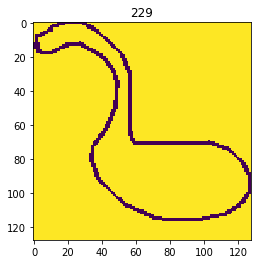

In [43]:
sample_n = 210
x_im = x_val[sample_n,:,:,0]
print (x_val.shape, val_chunk.shape)
plt.imshow(x_im)
plt.title(np.argmax(y_val, axis=1)[sample_n])
plt.show()

340


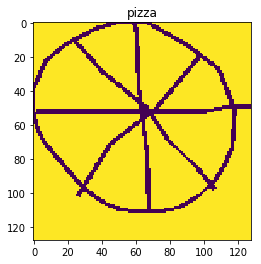

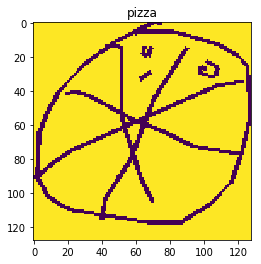

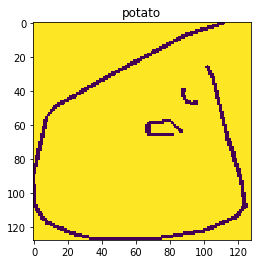

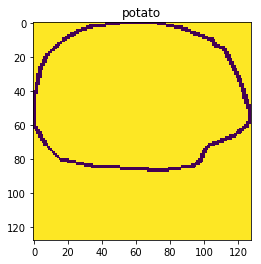

TypeError: Invalid dimensions for image data

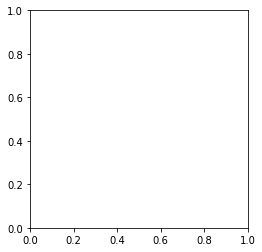

In [47]:
#plot some images; two images per class
import matplotlib.pyplot as plt
sample_n = 6
df = val_chunk
labels = df['label_text'].drop_duplicates().values
print (len(labels))
for label in labels[0:2]:
    idx = df['label_text'] == label
    n_label = df[idx].shape[0]
    label_chunk = df[idx]
    x, _ = make_data_from_chunk(label_chunk, num_classes=340)
    for i in range(x.shape[0]):
        if i < 2:
            x_im = x[i,:,:,0]
            plt.imshow(x_im)
            plt.title(label)
            plt.show()

In [9]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), activation='relu', input_shape=input_shape, padding='same'))
    model.add(Conv2D(32, (7, 7), strides=(2,2),activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())
    #model.add(Dense(250, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
# Exploring different learning rate
dictionary_list = []
for k in range(20):
    learning_rate = 2*10**(-np.random.rand()-2) #0.001-0.01
    print("learning_rate: " + str(learning_rate))
    model = cnn_model()
    model.compile(loss=losses.categorical_crossentropy,
          optimizer=optimizers.adam(lr=learning_rate, decay=0),
          metrics=['accuracy'])
    
    chunks = pd.read_csv(all_data, usecols=[1,3,5,6], header=None, chunksize=chunksize, skiprows=num_test)
    for i, chunk in enumerate(chunks):
        print("chunk" + str(i))
        x_train, y_train = make_data_from_chunk(chunk, num_classes=num_classes)
        model.fit(x_train, y_train,
              batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), shuffle=False, )
        d = model.history.history
        d = {k:v[0] for k,v in d.items() if k not in ['chunk_n', 'learning_rate']}
        d1 = {"chunk_n": i, "learning_rate": learning_rate}
        d.update(d1)
        dictionary_list.append(d)
        if i == 4:
            print('\n')
            break

In [ ]:
df = pd.DataFrame(dictionary_list)

In [ ]:
df.sort_values('val_acc', ascending=False)

In [19]:
df.to_csv('~/kaggle/cnn_lr0.001_ES.csv', index=False)

In [27]:
batch_size = 512
learning_rate = 0.00002
chunksize = 100000

In [18]:
model = cnn_model()
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.adam(lr=learning_rate, decay=0),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        800       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         110720    
__________

In [10]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=1, min_lr=1e-4, verbose=1, min_delta=0.001)
EarlyStopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


In [28]:
#load model
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [30]:
#compile loaded model
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.adam(lr=learning_rate, decay=0),
              metrics=['accuracy'])

In [31]:
chunks = pd.read_csv(all_data, usecols=[1,3,5,6], header=None, chunksize=chunksize, skiprows=num_val)
dictionary_list = []

#Decrease the epoch to 1 after 40 chunks, to expedite learning
for i, chunk in enumerate(chunks):
    if i < 40:
        num_epochs = 10
        
    else:
        num_epochs = 1
    
    print("chunk " + str(i))
    x_train, y_train = make_data_from_chunk(chunk, num_classes=num_classes)
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1, callbacks=[EarlyStopping],
          validation_data=(x_val, y_val), shuffle=False)
    d = model.history.history
    d = {k:v[0] for k,v in d.items() if k not in ['chunk_n', 'learning_rate']}
    d1 = {"chunk_n": i, "learning_rate": learning_rate}
    d.update(d1)
    dictionary_list.append(d)

chunk 417
Train on 91539 samples, validate on 2260 samples
Epoch 1/1
91539/91539 [==============================] - 51s 558us/step - loss: 0.6759 - acc: 0.8013 - val_loss: 0.6676 - val_acc: 0.8066
chunk 418
Train on 91497 samples, validate on 2260 samples
Epoch 1/1
91497/91497 [==============================] - 49s 540us/step - loss: 0.6782 - acc: 0.8006 - val_loss: 0.6671 - val_acc: 0.8097
chunk 419
Train on 91602 samples, validate on 2260 samples
Epoch 1/1
91602/91602 [==============================] - 51s 562us/step - loss: 0.6844 - acc: 0.7997 - val_loss: 0.6669 - val_acc: 0.8111
chunk 420
Train on 91599 samples, validate on 2260 samples
Epoch 1/1
91599/91599 [==============================] - 51s 561us/step - loss: 0.6793 - acc: 0.8020 - val_loss: 0.6663 - val_acc: 0.8106
chunk 421
Train on 91459 samples, validate on 2260 samples
Epoch 1/1
91459/91459 [==============================] - 52s 565us/step - loss: 0.6861 - acc: 0.7974 - val_loss: 0.6661 - val_acc: 0.8088
chunk 422
Train

In [32]:
#save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [33]:
#writing result to csv
df = pd.DataFrame(dictionary_list)
df.to_csv('~/kaggle/cnn_lr0.001_ES_EpochReduceAfter40_4.csv', index=False)

In [34]:
#Make a submission on Kaggle
test_data='~/kaggle/data/test_simplified.csv'

test_chunk = pd.read_csv(test_data)
#chunk.columns = ['drawing', 'recognized', 'label_text','label']
x_test = np.array([draw_it(v) for v in test_chunk['drawing'].values]).reshape(-1,imheight,imwidth,1)
y_test = model.predict(x_test)

In [35]:
test_chunk.head()

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [36]:
# map label number back to text
mapping = pd.read_csv(all_data, nrows=5000, header=None)
mapping_dict = dict(mapping[[6,5]].drop_duplicates().values)
mapping_dict = {k:'_'.join(v.split()) for k,v in mapping_dict.items()}

In [19]:
len(mapping_dict)

340

In [37]:
test_sorted = np.argsort(y_test)[:,337:340][:,::-1]
df_test = pd.DataFrame(test_sorted)
df_test = df_test.applymap(lambda x: mapping_dict[x])
df_test['word'] = df_test[0] + ' ' + df_test[1] + ' ' + df_test[2]

In [38]:
df_test['key_id'] = test_chunk['key_id']

In [39]:
df_test.head()

,0,1,2,word,key_id
0,radio,stereo,snorkel,radio stereo snorkel,9000003627287624
1,hockey_puck,bottlecap,pool,hockey_puck bottlecap pool,9000010688666847
2,The_Great_Wall_of_China,camel,castle,The_Great_Wall_of_China camel castle,9000023642890129
3,mountain,church,The_Eiffel_Tower,mountain church The_Eiffel_Tower,9000038588854897
4,fireplace,campfire,leaf,fireplace campfire leaf,9000052667981386


In [40]:
df_test[['key_id', 'word']].to_csv('test_output.csv', index=False)#df_test['word'] = df_test[[0,1,2]]